# Project II: Economic Growth 

This notebook will help you getting started with analyzing the growth dataset, `growth.csv`.

In [17]:
import pandas as pd 
import numpy as np 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from scipy.stats import norm
from sklearn.preprocessing import PolynomialFeatures

## Read data 

In [18]:
dat = pd.read_csv('growth.csv')
lbldf = pd.read_csv('labels.csv', index_col='variable')
lbl_all = lbldf.label.to_dict() # as a dictionary
print(f'The data contains {dat.shape[0]} rows (countries) and {dat.shape[1]} columns (variables).')

The data contains 214 rows (countries) and 85 columns (variables).


# Descriptive plots

<Axes: xlabel='lgdp_initial', ylabel='gdp_growth'>

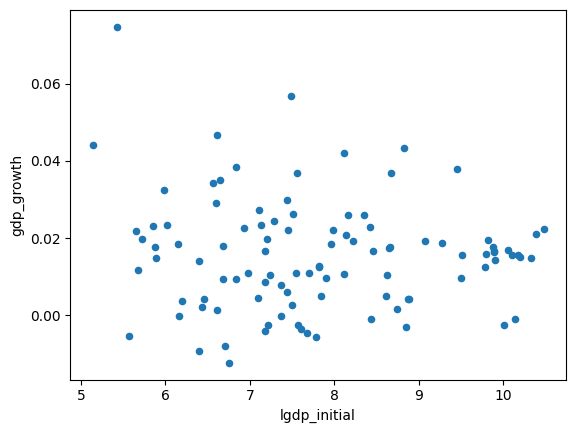

In [19]:
dat.plot.scatter(x='lgdp_initial', y='gdp_growth')

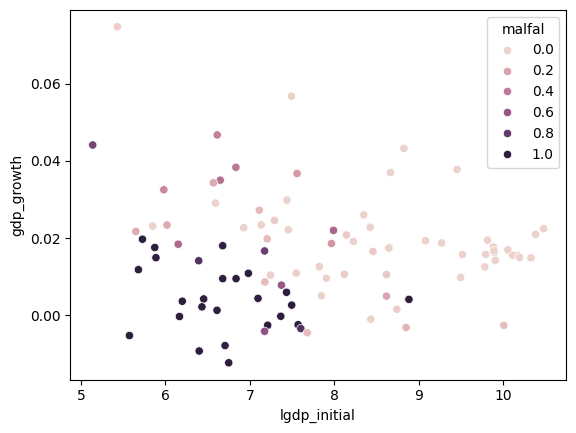

In [20]:
import seaborn as sns 
sns.scatterplot(x='lgdp_initial', y='gdp_growth', data=dat, hue='malfal');

# Collections of variables

In order to make the analysis simpler, it may be convenient to collect variables in sets that belong together naturally. 

In [21]:
# all available variables
vv_institutions = ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg'] 
vv_geography = [
        'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
        'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
        'africa',  'asia', 'oceania', 'americas' # 'europe' is the reference
]
vv_geneticdiversity = ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']
vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst'] # these are often missing: ['pd1', 'pop1']
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']
vv_danger = ['yellow', 'malfal',  'uvdamage']
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']
vv_educ = ['ls_bl', 'lh_bl'] # secondary, tertiary: we exclude 'lp_bl' (primary) to avoid rank failure 

vv_all = {'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources
         }
list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]

In [22]:
# convenient to keep a column of ones in the dataset
dat['constant'] = np.ones((dat.shape[0],))
print(dat.head())

  code  marketref  dem  demCGV  demBMR    demreg      lp_bl      ls_bl  \
0  AFG        NaN  0.0     0.0     0.0  0.000000   4.109822   0.564805   
1  AGO        NaN  NaN     NaN     NaN  0.031250        NaN        NaN   
2  ALB   9.090906  0.0     0.0     0.0  0.037037  32.111988  32.864277   
3  ARE        NaN  NaN     NaN     NaN       NaN        NaN        NaN   
4  ARG  34.144062  0.0     0.0     0.0  0.071429  72.400000  15.300000   

      lh_bl  tropicar  ...  capital_growth_pct_gdp_initial  \
0  1.096088  0.000000  ...                        5.463794   
1       NaN  1.000000  ...                             NaN   
2  2.935904  0.000000  ...                             NaN   
3       NaN       NaN  ...                             NaN   
4  4.000000  0.027089  ...                       24.440095   

   capital_growth_pct_gdp_now   gdp_initial       gdp_now  investment_rate  \
0                         NaN           NaN  2.138691e+10        10.576140   
1                   22.762

# Simple OLS

In [23]:
# 1. avoiding missings 
I = dat[['gdp_growth', 'lgdp_initial']].notnull().all(axis=1)

# 2. extract dataset 
y = dat.loc[I, 'gdp_growth'].values.reshape((-1,1)) * 100.0
X = dat.loc[I, ['constant','lgdp_initial']].values
print(X.shape)

betahat = np.linalg.inv(X.T @ X) @ X.T @ y
print(betahat)

(102, 2)
[[ 2.24792211]
 [-0.08713416]]


# Adding more controls

In [24]:
vs = vv_all['geography'] + vv_all['religion']
xs = ['lgdp_initial', 'pop_growth', 'investment_rate'] + vs

# avoiding missings
all_vars = ['gdp_growth'] + xs
I = dat[all_vars].notnull().all(1)

# extract data
X = dat.loc[I, xs].values
print(X.shape)
y = dat.loc[I,'gdp_growth'].values.reshape((-1,1)) * 100. #easier to read output when growth is in 100%

# add const. (unless this breaks the rank condition)
oo = np.ones((I.sum(),1))
X = np.hstack([X, oo])

xs.append('constant') # we put it in as the last element

# check the rank condition
K = X.shape[1]
assert np.linalg.matrix_rank(X) == X.shape[1], f'X does not have full rank'

# compute the OLS estimator
betas = np.linalg.inv(X.T @ X) @ X.T @ y

(89, 27)


In [25]:
# format nicely
print(f'Mean y = {y.mean(): 5.2f}% growth per year')
pd.DataFrame({'β': betas[:,0]}, index=xs).round(3)

Mean y =  1.52% growth per year


,β
lgdp_initial,-1.118
pop_growth,6.830
investment_rate,0.068
tropicar,-0.411
distr,-0.000
distcr,0.001
distc,-0.003
suitavg,-1.063
temp,-0.204
suitgini,-0.771


# Notes on the assignment
Test whether the data is consistent with the theory of beta convergence. Treat $\mathbf{z}_i$ as high-dim.
$$
g_i = \beta y_{i0} + \mathbf{z}_i'\gamma + u_i
$$
$y_{i0}$ is the initial log GDP per capita. The controls are $\mathbf{z}_i$ and $u_i$ is an idiosyncratic error term.
### Tasks
Core tasks:
1. Select regressors, see Overleaf for prioritized list.
2. Insert functions from exercise classes into functions_lasso.py.
3. Estimate model.
4. Construct confidence intervals.
5. Plot results.
6. Tabularize results.

### Workflow
1. Selection of regressors using BRT. Then implement BCCH afterwards, then CV.
    1. Remember standardization of variables (lecture 6 slide 22).
    2. Remember $c$ and $\alpha$ values, taken from BCCH paper. (adjusts rate of converge)
2. Estimate LS
3. Estimate LASSO
4. Estimate post-LASSO
5. Estimate post-double LASSO
6. Estimate post-partialling out LASSO (should be asymptotically equivalent to post-double LASSO selection)


### If time permits
1. Interpolation of missing data (or imputation).
    1. See bonus material under Project 2 on Absalon.

# User generated code

### Cleaner version of messy code:

### Messy code but workflow is correct:

In [26]:
from functions_lasso import *
%load_ext autoreload
%autoreload 2

# Supress scientific notation and only prints to 8 decimal places. All calculations will be done in full precision.
np.set_printoptions(suppress=True,precision=8)

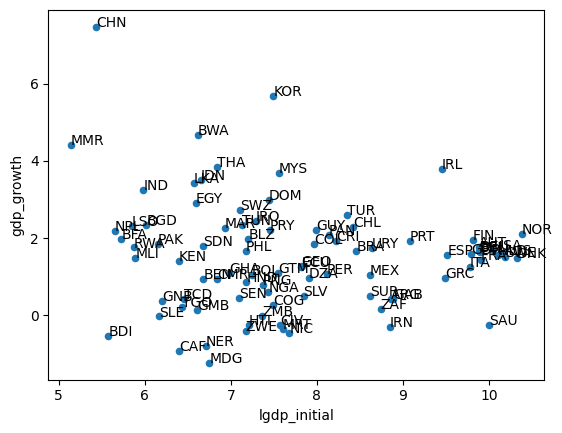

In [27]:
# Plot for selected countries.
country_code = dat.loc[I, 'code'] # country code for I criterion.
#print(country_code.shape[0] == X.shape[0]) # dimension check

data_selected = pd.DataFrame(X, columns=xs, index=country_code)

y_df = pd.DataFrame(y, columns=['gdp_growth'], index=country_code)
data_final = pd.concat([y_df, data_selected], axis=1)

ax_data = data_final.plot.scatter(x='lgdp_initial', y='gdp_growth')
for idx, row in data_final.iterrows():
    ax_data.annotate(idx, (row['lgdp_initial'], row['gdp_growth']))

In [28]:
# Core task 1.
%reload_ext autoreload

vs = vv_all['geography'] + vv_all['resources'] + vv_all['danger']
ds = ['lgdp_initial']
zs_basic = ['pop_growth', 'investment_rate']
zs = zs_basic + vs
xs = ds + zs

# avoiding missings
all_vars = ['gdp_growth'] + xs
I = dat[all_vars].notnull().all(1)

# extract data
D = dat.loc[I, ds].values
Z_basic = dat.loc[I, zs_basic].values
Z = dat.loc[I, zs].values
X = dat.loc[I, xs].values
y = dat.loc[I,'gdp_growth'].values.reshape((-1,1)) * 100. #easier to read output when growth is in 100%
X = standardize(X)
D = standardize(D)
Z = standardize(Z)
y = standardize(y)

# add const. (unless this breaks the rank condition)
# oo = np.ones((I.sum(),1))
# X_tilde = np.hstack([X, oo])
X_tilde = X
# xs.append('constant') # we put it in as the last element

# check the rank condition
K = X_tilde.shape[1]
assert np.linalg.matrix_rank(X) == X.shape[1], f'X does not have full rank'

In [29]:
# Core task 2.
%reload_ext autoreload

# ConvergenceWarnings is only a problem for small penalties. It still converges...
# import warnings
# from sklearn.exceptions import ConvergenceWarning
# warnings.filterwarnings("ignore", category=ConvergenceWarning)

penalty_grid = penalty_grid_gen(start=0.0001, stop=10, num=1000)
coefs, selected_var = coefs_Lasso(X_tilde, y, penalty=penalty_grid, penalty_type="Grid")


NameError: name 'coefs_Lasso' is not defined

In [ ]:
# Get the string output for selected variables.
def get_selected_var(selected_variables):
    xs_selected = []
    for i in range(0,len(selected_variables)):
        if selected_variables[i] == True:
            xs_selected.append(i)
    xs_varname = []

    for var_index in xs_selected:
        xs_varname.append(xs[var_index])

    return xs_varname


# Cross validation penalty, CV

fit_CV = LassoCV(cv=5, alphas=penalty_grid).fit(X_tilde,y)

# Investigate the penalty
penalty_CV = fit_CV.alpha_ 
print('Penalty_CV: ', round(penalty_CV,4))

# Investigate the coefficients
coeff_CV = fit_CV.coef_
print('Coefficients: ', np.round(coeff_CV))
print(coeff_CV[0])
# Investigate the selected variables
selected_variables_CV = (coeff_CV!=0)
print('Selected variables: ', get_selected_var(selected_variables_CV), len(get_selected_var(selected_variables_CV)))

# PSL
Z_J = X_tilde[:, selected_variables_CV]
print(Z_J.shape)
xx = Z_J #np.column_stack((np.ones(X_tilde.shape[0]),Z_J))
yy = np.array(y).reshape(-1,1)
# Calculate OLS estimate

coefs_PSL = np.linalg.inv(xx.T@xx)@xx.T@yy
alpha_PSL = coefs_PSL[0][0]
print(coefs_PSL)
# Calculate residuals
res_PSL = yy - xx@coefs_PSL

# Display alpha
print("alpha_PSL = ",alpha_PSL.round(2))

/Users/noahcarelse/github/UCPH/AdvMic_Assignment-2/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:1714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Penalty_CV:  0.021
Coefficients:  [-1. -0.  0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0. -0.  0.  0.
 -0.  0. -0.  0. -0.  0. -0. -0.  0.  0.  0.  0. -0. -0.]
-0.7278868462384337
Selected variables:  ['lgdp_initial', 'pop_growth', 'investment_rate', 'tropicar', 'distr', 'temp', 'suitgini', 'elevavg', 'area', 'cenlong', 'rough', 'landlock', 'africa', 'oceania', 'oilres', 'goldm', 'zinc', 'malfal'] 18
(88, 18)
[[-0.85808805]
 [ 0.03251408]
 [ 0.24803919]
 [ 0.2883741 ]
 [-0.10925177]
 [-0.64243344]
 [-0.07705383]
 [-0.41904621]
 [ 0.18531554]
 [ 0.29965311]
 [ 0.02937339]
 [ 0.08053771]
 [-0.11775356]
 [-0.07463279]
 [ 0.00772632]
 [-0.03028494]
 [ 0.08628847]
 [-0.61984114]]
alpha_PSL =  -0.86


In [ ]:
# BRT penalty
n,p = X.shape
sigma = np.std(y)
c = 1.05
alpha = 0.05
max_term = np.max((1/n) * np.sum((X_tilde**2),axis=0))**0.5 # Note: this equals 1 for standardized data, and is therefore not necessary to compute or include in the equation
penalty_BRT = c * sigma / np.sqrt(n) * norm.ppf(1 - alpha / (2*p)) # Note: Have divided by 2 due to Python definition of Lasso
print('Penalty_BRT: ', round(penalty_BRT,5))


fit_BRT = Lasso(alpha=penalty_BRT).fit(X_tilde,y)
coeff_BRT = fit_BRT.coef_
print('Coefficients: ', np.round(coeff_BRT,5))

# Selected variables
selected_variables_BRT = (coeff_BRT!=0)
print('Selected variables: ', get_selected_var(selected_variables_BRT))
print("lgdp_initial is dropped!")


Penalty_BRT:  0.35402
Coefficients:  [-0.      -0.       0.      -0.      -0.      -0.      -0.       0.
 -0.      -0.       0.       0.      -0.       0.       0.       0.
  0.       0.       0.      -0.      -0.       0.10993 -0.      -0.
 -0.      -0.       0.      -0.       0.      -0.      -0.04585 -0.     ]
Selected variables:  ['asia', 'malfal']
lgdp_initial is dropped!


In [ ]:
# BCCH pilot penalty
n,p = X.shape
c = 1.05
alpha = 0.05
yXscale = (np.max((X_tilde.T ** 2) @ ((y-np.mean(y)) ** 2) / n)) ** 0.5
print(yXscale)
penalty_pilot = c / np.sqrt(n) * norm.ppf(1-alpha/(2*p)) * yXscale # Note: Have divided by 2 due to Python definition of Lasso
print('Penalty_pilot: ', round(penalty_pilot, 5))

# Pilot estimates
#Create predicted value using Lasso 
pred = Lasso(alpha=penalty_pilot).fit(X_tilde,y).predict(X_tilde)

# Alternative: Manually
# coef_pilot = Lasso(alpha=penalty_pilot).fit(X_tilde,y).coef_
# coef_intercept = Lasso(alpha=penalty_pilot).fit(X_tilde,y).intercept_
# pred = (coef_intercept + X_tilde@coef_pilot)

# Updated penalty
eps = y - pred 
epsXscale = (np.max((X_tilde.T ** 2) @ (eps ** 2) / n)) ** 0.5
penalty_BCCH = c*norm.ppf(1-alpha/(2*p))*epsXscale/np.sqrt(n)
print('Penalty BCCH: ', round(penalty_BCCH, 5))

# Updated estimates
fit_BCCH = Lasso(alpha=penalty_BCCH).fit(X_tilde,y)
coeff_BCCH = fit_BCCH.coef_
print('Coefficients: ', np.round(coeff_BCCH))

# Selected variables
selected_variables_BCCH = (coeff_BCCH != 0)
print('Selected variables: ', get_selected_var(selected_variables_BCCH))

NameError: name 'n' is not defined

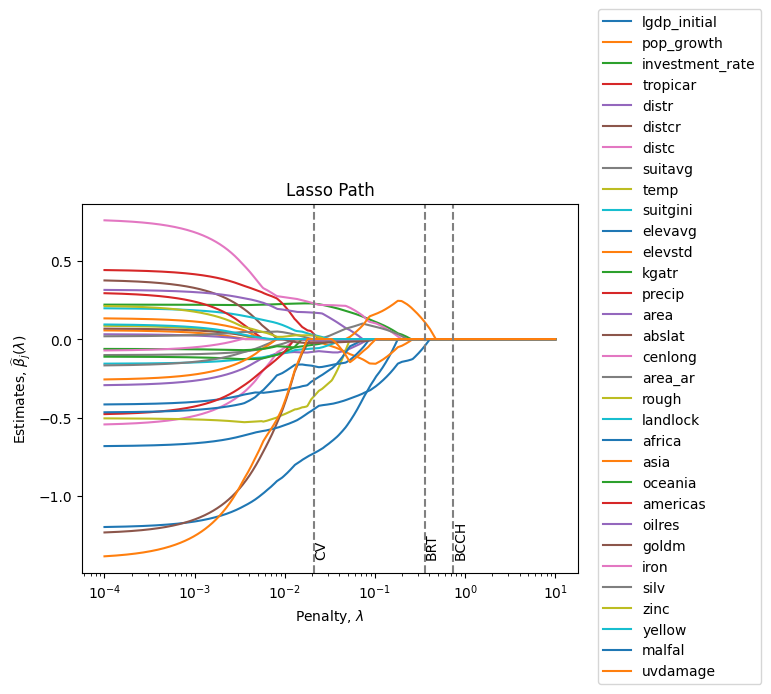

In [43]:
# Lasso path. 
# print(len(penalty_grid))
plot_lasso_path(penalty_grid, coefs, legends=xs, vlines={'BCCH':penalty_BCCH,'BRT':penalty_BRT, 'CV':penalty_CV})

In [44]:
# Coefficient table of LASSO estimates.
data_coefs = {'CV': coeff_CV, 'BRT': coeff_BRT, 'BCCH': coeff_BCCH}
df = pd.DataFrame(data_coefs, index=xs).astype(float)
# df

### Estimates for OLS, Post-Single LASSO (PSL), Post Double Lasso (PDL), Post Partialling Out Lasso (PPOL)
Since the above shows BRT and BCCH removes lgdp_initial, the obvious step is to only use DPL or PPOL. Or enforce lgdp_initial to remain unpenalized (same as regressing gdp_growth on all other controls without lgdp_intitial).

What do you guys think?

In [ ]:
%reload_ext autoreload
from sklearn.preprocessing import StandardScaler
vs = vv_all['geography'] + vv_all['danger'] + vv_all['resources'] # + vv_all['religion']
ds = ['lgdp_initial']
zs = ['pop_growth', 'investment_rate'] + vs
xs = ds + zs

all_vars = ['gdp_growth'] + xs
I = dat[all_vars].notnull().all(1)
# extract data
D = dat.loc[I, ds].values.reshape((-1,))
Z = dat.loc[I, zs].values
X = dat.loc[I, xs].values

y = dat.loc[I,'gdp_growth'].values.reshape((-1,)) #easier to read output when growth is in 100%
X_tilde = standardize(X)
D_tilde = standardize(D)
Z_tilde = standardize(Z)
y_tilde = standardize(y)

# check the rank condition
K = X_tilde.shape[1]
assert np.linalg.matrix_rank(X) == X.shape[1], f'X does not have full rank'

In [20]:
# OLS
coefs_OLS = np.linalg.inv(X_tilde.T@X_tilde)@X_tilde.T@y_tilde
alpha_OLS = coefs_OLS[-1] # Constant is the last element not first.
# print(alpha_OLS)
res_OLS = y_tilde - X_tilde@coefs_OLS
# maybe we should use implement robust here, since we also use BCCH (assuming heteroscedasticity) For now homoscedasticity.
# ^will look into later.

In [25]:
# PSL
# BRT penalty
def BRT(X_tilde,y):
    (N,p) = X_tilde.shape
    sigma = np.std(y, ddof=1)
    c=1.1
    alpha=0.05

    penalty_BRT= (sigma*c)/np.sqrt(N)*norm.ppf(1-alpha/(2*p))

    return penalty_BRT
penalty_BRT = BRT(X_tilde,y_tilde)

fit_BRT = Lasso(alpha=penalty_BRT).fit(X_tilde,y_tilde)
coeff_BRT = fit_BRT.coef_
print('Coefficients: ', np.round(coeff_BRT,5))
# Selected variables
selected_variables_BRT = (coeff_BRT!=0)
print('Selected variables: ', get_selected_var(selected_variables_BRT))
Z_J = X_tilde[:, selected_variables_BRT]

xx = np.column_stack([D_tilde, Z_J]) # np.ones(X_tilde.shape[0]), 
yy = y_tilde
coefs_PSL = np.linalg.inv(xx.T@xx)@xx.T@yy

alpha_PSL = coefs_PSL[0]
res_PSL = y_tilde - xx@coefs_PSL
print("coeficients = ", coefs_PSL.round(3))
print("alpha_PSL = ",alpha_PSL.round(3))

Coefficients:  [-0.      -0.       0.      -0.      -0.      -0.      -0.       0.
 -0.      -0.       0.       0.      -0.       0.       0.       0.
  0.       0.       0.      -0.      -0.       0.0932  -0.      -0.
 -0.      -0.02912 -0.      -0.      -0.       0.      -0.       0.     ]
Selected variables:  ['asia', 'malfal']
coeficients =  [-0.376  0.294 -0.59 ]
alpha_PSL =  -0.376


In [22]:
# DPL
penalty_BRTyx = BRT(X_tilde, y_tilde)
fit_yx = Lasso(alpha=penalty_BRTyx).fit(X_tilde,y_tilde)
coefs_yx = fit_yx.coef_
resid_yx = y_tilde - fit_yx.predict(X_tilde)
penalty_BRT_ZD = BRT(Z_tilde, D_tilde)
fit_BRT_ZD = Lasso(alpha=penalty_BRT_ZD).fit(Z_tilde,D_tilde)
coefs_ZD = fit_BRT_ZD.coef_
resid_ZD = D_tilde - fit_BRT_ZD.predict(Z_tilde)
print(resid_ZD.shape, resid_yx.shape)
num = resid_ZD@resid_yx
denom = resid_ZD@D_tilde
alpha_DPL = num/denom
print(alpha_DPL)


(88,) (88,)
-0.2510521050807866


In [ ]:
# PPOL

# Lasso (not in use)

In [9]:
for key in vv_all.keys():
    print(f'Number of variables in {key}: {len(vv_all[key])}')
    print(f'The variables are: {", ".join(vv_all[key])}')
    # print(f'Missing values in {key}: {dat[vv_all[key]].isnull().sum()}')


Number of variables in institutions: 5
The variables are: marketref, dem, demCGV, demBMR, demreg
Number of variables in geography: 21
The variables are: tropicar, distr, distcr, distc, suitavg, temp, suitgini, elevavg, elevstd, kgatr, precip, area, abslat, cenlong, area_ar, rough, landlock, africa, asia, oceania, americas
Number of variables in geneticdiversity: 4
The variables are: pdiv, pdiv_aa, pdivhmi, pdivhmi_aa
Number of variables in historical: 5
The variables are: pd1000, pd1500, pop1000, pop1500, ln_yst
Number of variables in religion: 3
The variables are: pprotest, pcatholic, pmuslim
Number of variables in danger: 3
The variables are: yellow, malfal, uvdamage
Number of variables in resources: 5
The variables are: oilres, goldm, iron, silv, zinc
Number of variables in all: 46
The variables are: marketref, dem, demCGV, demBMR, demreg, tropicar, distr, distcr, distc, suitavg, temp, suitgini, elevavg, elevstd, kgatr, precip, area, abslat, cenlong, area_ar, rough, landlock, africa

In [13]:
I = dat[['gdp_growth', 'lgdp_initial'] + vv_all["all"]].notnull().all(axis=1)
x = dat.loc[I, vv_all["geography"]]
print(x.shape)
print(I)
# Correct formula: max_j sqrt((1/n) * sum_i x_ij^2 * (y_i - ybar)^2)y_centered = y - np.mean(y)yXscale = np.sqrt(np.max((1/n) * (X_tilde**2).T @ (y_centered**2)))penalty_pilot = c / np.sqrt(n) * norm.ppf(1-alpha/(2*p)) * yXscaleprint('Penalty_pilot: ', round(penalty_pilot, 2))# Pilot estimates# Create predicted value using Lasso pred = Lasso(alpha=penalty_pilot).fit(X_tilde, y).predict(X_tilde)# Updated penalty with residualseps = y - pred.reshape(-1, 1)epsXscale = np.sqrt(np.max((1/n) * (X_tilde**2).T @ (eps**2)))penalty_BCCH = c * norm.ppf(1-alpha/(2*p)) * epsXscale / np.sqrt(n)print('Penalty BCCH: ', round(penalty_BCCH, 2))# Updated estimatesfit_BCCH = Lasso(alpha=penalty_BCCH).fit(X_tilde, y)coeff_BCCH = fit_BCCH.coef_print('Coefficients: ', np.round(coeff_BCCH, 2))# Selected variablesselected_variables_BCCH = (coeff_BCCH != 0)print('Selected variables: ', get_selected_var(selected_variables_BCCH))

(63, 21)
0      False
1      False
2      False
3      False
4       True
       ...  
209    False
210    False
211    False
212    False
213    False
Length: 214, dtype: bool


In [ ]:
# check missing values of the z numpy array 
missing_values = np.isnan(y).sum()
print("Missing values in z array:", missing_values)


In [ ]:
# Make a function that calculates BRT. Hint: You implemented a version of this last week
def BRT(X_tilde, y, c=1.1, alpha=0.05):
    (N,p) = X_tilde.shape
    sigma = np.std(y, ddof=1)
    penalty_BRT= (sigma*c)/np.sqrt(N)*norm.ppf(1-alpha/(2*p))
    return penalty_BRT

penalty_BRTyx = BRT(X,y)
print("lambda_BRT =",penalty_BRTyx.round(2))

In [ ]:
fit_BRTyx = Lasso(alpha=penalty_BRTyx).fit(X, y)
coefs = fit_BRTyx.coef_
Z_J = X[:, coefs[0:]!=0] # Extract coeffs diff from zero. 
print("The number of variables in Z_J is {}".format(Z_J.shape[1]))

In [ ]:
def plot_lasso_path(penalty_grid, coefs, legends, vlines: dict = None):
    """
    Plots the coefficients as a function of the penalty parameter for Lasso regression.

    Parameters:
    penalty_grid (array-like): The penalty parameter values.
    coefs (array-like): The estimated coefficients for each penalty value.
    legends (list): The labels for each coefficient estimate.
    vlines (dict, optional): A dictionary of vertical lines to add to the plot. The keys are the names of the lines and the values are the penalty values where the lines should be drawn.
    
    """
    # Initiate figure 
    fig, ax = plt.subplots()

    # Plot coefficients as a function of the penalty parameter
    ax.plot(penalty_grid, coefs)

    # Set log scale for the x-axis
    ax.set_xscale('log')

    # Add labels
    plt.xlabel('Penalty, $\lambda$')
    plt.ylabel(r'Estimates, $\widehat{\beta}_j(\lambda)$')
    plt.title('Lasso Path')

    # Add legends
    lgd=ax.legend(legends,loc=(1.04,0))
    
    # Add vertical lines
    if vlines is not None:
        for name, penalty in vlines.items():
            ax.axvline(x=penalty, linestyle='--', color='grey')
            plt.text(penalty,-80000,name,rotation=90)

    # Display plot
    plt.show()
    plt.close()


In [ ]:
# Create a grid using numpy.geomspace
penalty_grid = np.geomspace(0.01, 80000, num = 28)
Xnames = x.columns
print(y.shape)
print(X.shape)
print(coefs.shape)
print(penalty_grid.shape)
print(Xnames.shape)

In [ ]:
# plot_lasso_path(penalty_grid, coefs, Xnames)